# Clasificación de texto usando embeddings pre-entrenados

Este notebook presenta la creación de clasificadores de texto para determinar el autor de un texto entre 3 posibles autores usando embeddings pre-entrenados de `Glove`.

## 0. Importación de Librerias

In [127]:
import requests
import zipfile
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

from tensorflow.keras import (
    utils,
    layers,
    models,
    callbacks
)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [220]:
# Cargamos el dataset
df = pd.read_csv('data/classifier/sentences.csv')
df.head()

,author,sentence
0,Jane Austen,"Their estate was large, and their residence wa..."
1,Jane Austen,The late owner of this estate was a single man...
2,Jane Austen,"But her death, which happened ten years before..."
3,Jane Austen,"Henry Dashwood to his wishes, which proceeded ..."
4,Jane Austen,"The son, a steady respectable young man, was a..."


## 1. Preprocesamiento

In [201]:
# Dividir el dataframe en conjuntos de entrenamiento, prueba y validación
train_df, temp_df = train_test_split(df, train_size=0.7, random_state=42)
val_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)

x_train, y_train = train_df['sentence'], train_df['author']
x_val, y_val = val_df['sentence'], val_df['author']
x_test, y_test = test_df['sentence'], test_df['author']

In [100]:
# Cargamos los embeddings pre-entrenados de Glove
glove_download_url = "https://nlp.stanford.edu/data/glove.6B.zip"

response = requests.get(glove_download_url)

In [202]:
def load_embeddings(dim: int) -> dict[str, np.ndarray[float]]:
    """
    Carga los embeddings pre-entrenados de Glove y los devuelve en un diccionario
    donde la llave corresponde al token y el valor es un array de numpy con los
    coeficientes del embedding.

    Args:
        dim (int): Dimensión de los embeddings a cargar
    Throws:
        FileNotFoundError: Si no se encuentra el archivo de embeddings
    Returns:
        dict[str, np.ndarray[float]]: Diccionario con los embeddings cargados
    """
    glove_zip_path = "glove.6B.zip"
    glove_path = f'glove.6B.{dim}d.txt'

    with open(glove_zip_path, 'wb') as file:
        file.write(response.content)

    with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
        zip_ref.extract(glove_path, "data/models/glove/")

    # Cargamos los embeddings en un diccionario
    embeddings_index = {}

    with open(os.path.join("data/models/glove/", glove_path), 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    return embeddings_index

## 2. Arquitectura #1

In [203]:
# Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)
# Tamano vocabulario
vocab_size = len(tokenizer.word_index) + 1
# Tamano oraciones
max_length = 250

In [204]:
## Preparacion de x_train
sequences = tokenizer.texts_to_sequences(x_train)
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post', truncating='post')

# Visualizar las secencias y los indices en el vocabulario
print(tokenizer.sequences_to_texts(sequences[:1]))
padded_sequences[0]

['“you must make my apologies to your friend but so good a charade must not be confined to one or two he may be sure of every woman’s approbation while he writes with such gallantry ”']


array([ 303,   85,  174,   44, 4697,    3,   67,  243,   25,   34,   96,
          5, 4245,   85,   18,   26, 2858,    3,   39,   50,  106,    7,
        157,   26,  286,    4,  111, 1995, 2377,  146,    7, 2655,   12,
         71, 3549,   15,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [205]:
## Preparacion de y_train
labelEncoder = LabelEncoder()
encoding = labelEncoder.fit_transform(y_train)

labels = utils.to_categorical(encoding, num_classes=3)
labels.shape

(12144, 3)

In [206]:
## Preparacion de val
val_x_data = tokenizer.texts_to_sequences(x_val)
val_padded_sequences = pad_sequences(val_x_data, maxlen=max_length, padding='post', truncating='post')

val_y_data = labelEncoder.transform(y_val)
val_labels = utils.to_categorical(val_y_data, num_classes=3)

In [207]:
def init_model(embeddings_index: dict[str, np.ndarray[float]], embedding_dim: int):
    """
    Inicializa el clasificador usando embeddings pre-entrenados de Glove de cierta dimension

    Args:
        embeddings_index (dict[str, np.ndarray[float]]): Diccionario con los embeddings pre-entrenados
        embedding_dim (int): Dimension de los embeddings

    Returns:
        models.Sequential: Modelo inicializado
    """
    # Crear matriz de embeddings pre-entrenados
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

    # Capa de Embedding
    embedding_layer = layers.Embedding(vocab_size,
                                    embedding_dim,
                                    trainable=False)
    embedding_layer.build((1, ))
    embedding_layer.set_weights([embedding_matrix])

    # Modelo secuencial
    model = models.Sequential([
        layers.Input(shape=(max_length, )),
        embedding_layer,
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(3, activation='softmax')
    ])

    return model

In [208]:
def eval_model(model):
    """
    Evalua el modelo de clasificación

    Args:
        model (models.Sequential): Modelo a evaluar

    Returns:
        None
    """
    # Preprocesar x_test
    test_sequences = tokenizer.texts_to_sequences(x_test)
    test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

    # Hacer las predicciones
    predictions = model.predict(test_padded_sequences)
    predicted_classes = np.argmax(predictions, axis=1)

    # Codificar y_test
    y_test_encoded = labelEncoder.transform(y_test)

    # Generar reporte de clasificación
    report = classification_report(y_test_encoded, predicted_classes, target_names=labelEncoder.classes_)

    print(report)

In [209]:
def plot_history(history):
    """
    Grafica la historia de entrenamiento del modelo

    Args:
        history (tensorflow.python.keras.callbacks.History): Historia de entrenamiento
    """
    ## Visualizar la curva de aprendizaje
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    epochs = range(1, len(loss_values) + 1)
    plt.plot(epochs, loss_values, 'r', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    

### 2.1. 50D

In [210]:
# Embeddings
embedding_dim = 50
embeddings_index = load_embeddings(embedding_dim)

In [211]:
model_50 = init_model(embeddings_index, embedding_dim)
model_50.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_29 (Embedding)        │ (None, 250, 50)        │     1,179,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_25 (Flatten)            │ (None, 12500)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_54 (Dense)                │ (None, 512)            │     6,400,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_55 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,581,751 (28.92 MB)

 Trainable params: 6,402,051 (24.42 MB)

 Non-trainable params: 1,179,700 (4.50 MB)

In [212]:
model_callbacks = [
    callbacks.EarlyStopping(patience=5, monitor="val_loss")
]

model_50.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
history_50 = model_50.fit(
    padded_sequences, 
    labels, 
    epochs=20, 
    batch_size=128, 
    validation_data=(val_padded_sequences, val_labels),
    callbacks=model_callbacks)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - accuracy: 0.5982 - loss: 0.9630 - val_accuracy: 0.7014 - val_loss: 0.6827
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.7423 - loss: 0.6109 - val_accuracy: 0.6983 - val_loss: 0.6704
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.7837 - loss: 0.5278 - val_accuracy: 0.7237 - val_loss: 0.6372
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8273 - loss: 0.4367 - val_accuracy: 0.7283 - val_loss: 0.6424
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.8513 - loss: 0.3823 - val_accuracy: 0.7198 - val_loss: 0.6354
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - accuracy: 0.8818 - loss: 0.3190 - val_accuracy: 0.7321 - val_loss: 0.6754
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.9089 - loss: 0.2633 - val_accuracy: 0.7333 - val_loss: 0.6925
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.9304 - loss: 0.2097 - val_accuracy: 0.7248 - v

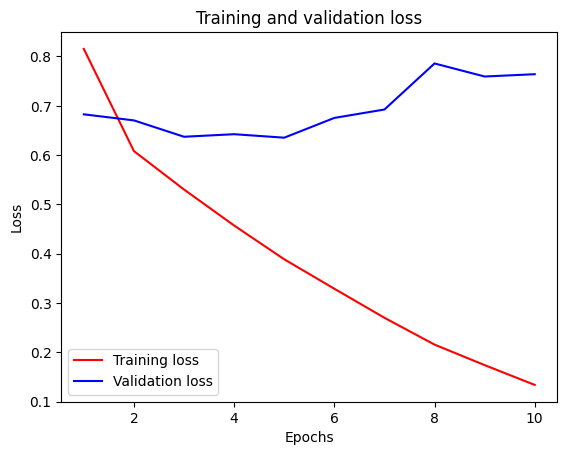

In [213]:
plot_history(history_50)

In [214]:
eval_model(model_50)

82/82 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

 James Joyce       0.66      0.41      0.50       439
 Jane Austen       0.65      0.74      0.69       601
 Leo Tolstoy       0.79      0.83      0.81      1563

    accuracy                           0.74      2603
   macro avg       0.70      0.66      0.67      2603
weighted avg       0.73      0.74      0.73      2603



### 2.2. 100D

In [215]:
# Embeddings
embedding_dim = 100
embeddings_index = load_embeddings(embedding_dim)

In [216]:
model_100 = init_model(embeddings_index, embedding_dim)
model_100.summary()

Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ (None, 250, 100)       │     2,359,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_26 (Flatten)            │ (None, 25000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_56 (Dense)                │ (None, 512)            │    12,800,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_57 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,161,451 (57.84 MB)

 Trainable params: 12,802,051 (48.84 MB)

 Non-trainable params: 2,359,400 (9.00 MB)

In [217]:
model_callbacks = [
    callbacks.EarlyStopping(patience=5, monitor="val_loss")
]

model_100.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
history_100 = model_100.fit(
    padded_sequences, 
    labels, 
    epochs=20, 
    batch_size=128, 
    validation_data=(val_padded_sequences, val_labels),
    callbacks=model_callbacks)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step - accuracy: 0.5819 - loss: 1.1159 - val_accuracy: 0.6910 - val_loss: 0.6928
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - accuracy: 0.7181 - loss: 0.6498 - val_accuracy: 0.7029 - val_loss: 0.6850
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - accuracy: 0.7790 - loss: 0.5360 - val_accuracy: 0.7398 - val_loss: 0.5998
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 58ms/step - accuracy: 0.8157 - loss: 0.4615 - val_accuracy: 0.7402 - val_loss: 0.6149
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 62ms/step - accuracy: 0.8438 - loss: 0.4030 - val_accuracy: 0.7471 - val_loss: 0.6103
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step - accuracy: 0.8652 - loss: 0.3482 - val_accuracy: 0.7452 - val_loss: 0.6256
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 14s 150ms/step - accuracy: 0.8908 - loss: 0.2987 - val_accuracy: 0.7425 - val_loss: 0.6421
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 13s 137ms/step - accuracy: 0.9025 - loss: 0.2603 - val_accuracy: 0.7502

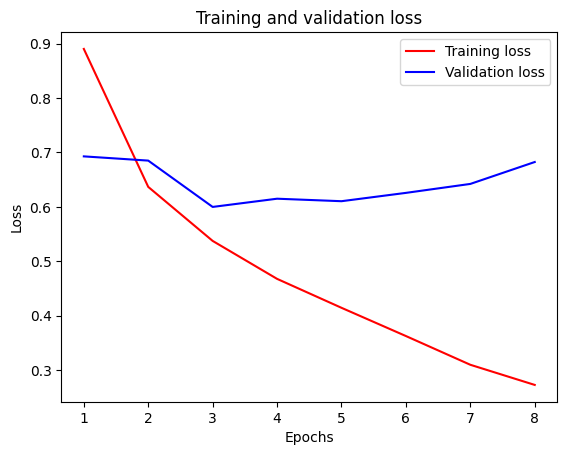

In [218]:
plot_history(history_100)

In [219]:
eval_model(model_100)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

 James Joyce       0.74      0.42      0.54       439
 Jane Austen       0.72      0.70      0.71       601
 Leo Tolstoy       0.78      0.88      0.83      1563

    accuracy                           0.76      2603
   macro avg       0.75      0.67      0.69      2603
weighted avg       0.76      0.76      0.75      2603



## 2.3. 300D

In [195]:
# Embeddings
embedding_dim = 300
embeddings_index = load_embeddings(embedding_dim)

In [196]:
model_300 = init_model(embeddings_index, embedding_dim)
model_300.summary()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_28 (Embedding)        │ (None, 250, 300)       │     7,078,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 75000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 512)            │    38,400,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3)              │         1,539 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 45,480,251 (173.49 MB)

 Trainable params: 38,402,051 (146.49 MB)

 Non-trainable params: 7,078,200 (27.00 MB)

In [197]:
model_callbacks = [
    callbacks.EarlyStopping(patience=5, monitor="val_loss")
]

model_300.compile(
    loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"]
)
history_300 = model_300.fit(
    padded_sequences, 
    labels, 
    epochs=20, 
    batch_size=128, 
    validation_data=(val_padded_sequences, val_labels),
    callbacks=model_callbacks)

Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 159ms/step - accuracy: 0.5989 - loss: 0.9897 - val_accuracy: 0.7302 - val_loss: 0.6330
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 16s 167ms/step - accuracy: 0.8019 - loss: 0.4883 - val_accuracy: 0.7644 - val_loss: 0.5597
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 18s 193ms/step - accuracy: 0.8805 - loss: 0.3299 - val_accuracy: 0.7683 - val_loss: 0.5606
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 35s 355ms/step - accuracy: 0.9173 - loss: 0.2297 - val_accuracy: 0.7625 - val_loss: 0.6512
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 19s 199ms/step - accuracy: 0.9516 - loss: 0.1503 - val_accuracy: 0.7679 - val_loss: 0.6843
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 233ms/step - accuracy: 0.9681 - loss: 0.1060 - val_accuracy: 0.7663 - val_loss: 0.7824
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 22s 229ms/step - accuracy: 0.9774 - loss: 0.0739 - val_accuracy: 0.7598 - val_loss: 0.7875


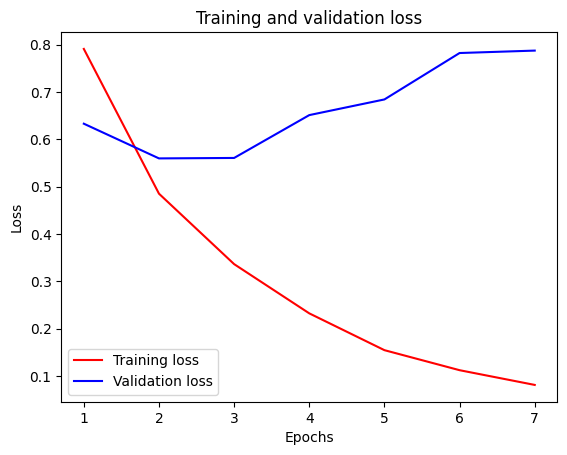

In [198]:
plot_history(history_300)

In [199]:
eval_model(model_300)

82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
              precision    recall  f1-score   support

 James Joyce       0.75      0.41      0.53       439
 Jane Austen       0.77      0.72      0.74       601
 Leo Tolstoy       0.79      0.91      0.85      1563

    accuracy                           0.78      2603
   macro avg       0.77      0.68      0.71      2603
weighted avg       0.78      0.78      0.77      2603

